# AMPLAB Module 4 Machine Listening - Sound Classification

This notebook includes the code to run a simple sound classification experiment using BSD10k dataset. We have already pre-computed embeddings of different types for all the sounds in BSD10k, so you don't need to deal with the audio. You should be able to run this notebook locally or in Google Colab without problems.

In order to run this notebook locally, you'll need to create a Python virtual environment and install the requirements (`pip install -r requirements.txt`). Also, you'll need to download the file  `amplab_machine_listening_module_data.zip` that [you'll find in this shared folder](https://drive.google.com/drive/folders/1FHEmzEXgBV1CCAWo_F3KDpw9QM5ecuZf?usp=sharing), and place it uncompressed next to this notebook (the uncompressed folder should be named `amplab_machine_listening_module_data`).

If running in Google Colab, you'll need to make a copy of this notebook somewhere in your Google Drive, and add a shortcut to the `amplab_data` shared folder next to your notebook (the shortcut must be named same as the folder, `amplab_data`). Then run the cells normally. Note that before running the first cell, you'll need to update the `%cd ...` path to set the working directory to the folder where the notebook (and the shortcut) are placed within your Google Drive. If in Colab, running the first cell will take some minutes as it needs to copy some data and unzip.

This work is similar to that of a paper we published at DCASE 2024:
[Anastasopoulou, Panagiota, et al. "Heterogeneous sound classification with the Broad Sound Taxonomy and Dataset." DCASE Workshop (2024)](https://dcase.community/documents/workshop2024/proceedings/DCASE2024Workshop_Anastasopoulou_39.pdf).

In [1]:
try:
  from google.colab import drive
  # If this does not fail, it means we're running in a Colab environment

  # First mount google drive
  drive.mount('/content/drive')

  # Set the working directory to the directory where this notebook has been placed.
  # This directory should have a Google Drive shortcut to the "amplab_data" shared folder.
  # Edit the below to point to the Google Drive directory where this notebook is located.
  %cd '/content/drive/MyDrive/SMC/AMPLab2425/AMPLAB 2025 Module 4 - Machine Listening'

  # Now copy data files to the colab runtime local storage and uncompress the .zip file.
  # By placing data files in the notebook runtime local storage, we will make data loading much faster in the cells below.
  !cp "amplab_data/amplab_machine_listening_module_data.zip" /content/amplab_machine_listening_module_data.zip
  !unzip  -u /content/amplab_machine_listening_module_data.zip -d /content/
  DATA_FOLDER = '/content/amplab_machine_listening_module_data'

except:
  # Not running in Colab
  DATA_FOLDER = 'amplab_machine_listening_module_data'

import os
import pandas as pd
import numpy as np
from IPython.display import display, IFrame
import matplotlib.pyplot as plt
import json
import sys
import random

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Data preparation

In [2]:
# Load dataset metadata
dataset_df = pd.read_csv(open(os.path.join(DATA_FOLDER, 'BSD10k_metadata.csv')))
taxonomy_names = json.load(open(os.path.join(DATA_FOLDER, 'taxonomy_names.json')))
display(dataset_df)
display(taxonomy_names)

,sound_id,class,class_idx,class_top,set,uploader,license,tags,title
0,185755,fx-o,11,fx,train,marcgp13,http://creativecommons.org/licenses/by/3.0/,"campus-upf,UPF-CS13,microwave,heat,bell,noise",microwave_oven.wav
1,358405,is-w,5,is,train,MTG,http://creativecommons.org/licenses/by/3.0/,"good-sounds,single-note,multisample,sax,neuman...",Sax Alto - F5
2,358760,is-w,5,is,train,MTG,http://creativecommons.org/licenses/by/3.0/,"good-sounds,sax,neumann-U87,GsharpMajor,scale,...",Sax Alto - G# Major
3,432206,fx-o,11,fx,train,curesforbrokenhearts,http://creativecommons.org/publicdomain/zero/1.0/,"egg-shaker,shaker,percussion",EGG SHAKER
4,80630,sp-s,8,sp,train,tim.kahn,https://creativecommons.org/licenses/by/4.0/,"american,english,female,fight,speak,talk,text,...",mechanics.wav
...,...,...,...,...,...,...,...,...,...
10304,102106,fx-h,14,fx,train,sagetyrtle,http://creativecommons.org/publicdomain/zero/1.0/,"applauding,applause,binaural,cheer,cheering,cl...",072510_crowd_cheer_01.wav
10305,196075,fx-h,14,fx,train,arnaud coutancier,http://creativecommons.org/licenses/by-nc/3.0/,"children,laughter,child,laugh,field,recording,...",Children's laughter #31 rires d'enfants.wav
10306,164689,fx-ex,17,fx,train,deleted_user_2104797,http://creativecommons.org/publicdomain/zero/1.0/,"speak,cartoon,speech,phone,telephone,babble,of...",Phone_voice_cartoon.wav
10307,61752,sp-s,8,sp,train,dobroide,https://creativecommons.org/licenses/by/4.0/,"insults,male,spanish,vocal",insultos045.wav


{'m-sp': 'Solo percussion',
 'm-si': 'Solo instrument',
 'm-m': 'Multiple instruments',
 'm-other': 'Other',
 'is-p': 'Percussion',
 'is-s': 'String',
 'is-w': 'Wind',
 'is-k': 'Keyboard',
 'is-e': 'Synths / Electronic',
 'is-other': 'Other',
 'sp-s': 'Solo speech',
 'sp-c': 'Conversation / Crowd',
 'sp-p': 'Processed / Synthetic',
 'sp-other': 'Other',
 'fx-o': 'Objects / House appliances',
 'fx-v': 'Vehicles',
 'fx-m': 'Other mechanisms, engines, machines',
 'fx-h': 'Human sounds and actions',
 'fx-a': 'Animals',
 'fx-n': 'Natural elements and explosions',
 'fx-d': 'Design',
 'fx-ex': 'Experimental',
 'fx-el': 'Electronic & Design',
 'fx-other': 'Other',
 'ss-n': 'Nature',
 'ss-i': 'Indoors',
 'ss-u': 'Urban',
 'ss-s': 'Synthetic / Artificial',
 'ss-other': 'Other',
 'm': 'Music',
 'is': 'Instrument samples',
 'ss': 'Soundscapes',
 'fx': 'Sound effects',
 'sp': 'Speech'}

#### The Broad Sound Taxonomy

![Broad Sound Taxonomy](https://raw.githubusercontent.com/allholy/BSD10k/refs/heads/main/BST_diagram.png)

In [3]:
# Utils function to be able to listen to actual sounds
# WARNING: it could be that some sounds in BSD10k are not available anymore in Freesound (e.g., removed by the user)

def show_sound_player(sound_id):
  display(IFrame(f'https://freesound.org/embed/sound/iframe/{sound_id}/simple/medium/', width=596, height=100))


# Let's listen to some sounds of each class
for class_key in taxonomy_names.keys():
  class_df = dataset_df[dataset_df['class']==class_key]
  if len(class_df) > 0:
    print(taxonomy_names[class_key])
    show_sound_player(class_df.iloc[0]['sound_id'])
    show_sound_player(class_df.iloc[1]['sound_id'])
    show_sound_player(class_df.iloc[2]['sound_id'])


Solo percussion


Solo instrument


Multiple instruments


Percussion


String


Wind


Keyboard


Synths / Electronic


Solo speech


Conversation / Crowd


Processed / Synthetic


Objects / House appliances


Vehicles


Other mechanisms, engines, machines


Human sounds and actions


Animals


Natural elements and explosions


Experimental


Electronic & Design


Nature


Indoors


Urban


Synthetic / Artificial


## Load data and train model

In [4]:
# Load dataset embeddings
# NOTE: here you can choose between different types of embeddings

def load_embeddings_for_dataset(df, embeddings_folder):
  # Returns a numpy array of shape (n, d) where "n" is the number of sounds in the dataset and "d" is the number of dimensions of the embeddings
  # Available embedding types: "clap", "fs_similarity", "fsdsinet", "mfcc", "fsdsinet_frames", "mfcc_frames"
  # NOTE: if you are loading embeddings which have been stored frame by frame (i.e. those ending with "_frames"), you'll need to add some code
  # here to summarize them into a one-dimensional vectors before adding them to the returned numpy array.

  base_dir = os.path.join(DATA_FOLDER, 'embeddings', embeddings_folder)
  filenames = [os.path.join(base_dir, f'{df.iloc[i]["sound_id"]}.npy') for i in range(len(df))]
  example_embedding_vector = np.load(filenames[0])
  num_dimensions = len(example_embedding_vector)

  print(f'Will load {len(filenames)} points of data with {num_dimensions} dimensions each')
  X = np.zeros((len(filenames), num_dimensions))
  for i, fn in enumerate(filenames):
    if (i + 1) % 100 == 0:
      sys.stdout.write(f'\r{i + 1}/{len(filenames)}                  ')
      sys.stdout.flush()
    X[i, :] = np.load(fn)
  sys.stdout.write(f'\rLoaded {len(filenames)} embeddings from "{embeddings_folder}"!')
  print()

  return X

X_fsdinet = load_embeddings_for_dataset(dataset_df, embeddings_folder="fsdsinet")
X_mfcc = load_embeddings_for_dataset(dataset_df, embeddings_folder="mfcc")
X_clap = load_embeddings_for_dataset(dataset_df, embeddings_folder="clap")
X_fs_similarity = load_embeddings_for_dataset(dataset_df, embeddings_folder="fs_similarity")

Will load 10309 points of data with 512 dimensions each
Loaded 10309 embeddings from "fsdsinet"!
Will load 10309 points of data with 13 dimensions each
Loaded 10309 embeddings from "mfcc"!
Will load 10309 points of data with 512 dimensions each
Loaded 10309 embeddings from "clap"!
Will load 10309 points of data with 100 dimensions each
Loaded 10309 embeddings from "fs_similarity"!


In [5]:
# Load ground truth labels
def get_ground_truth_vector(df):
  return np.array([taxonomy_names[df.iloc[i]["class"]] for i in range(len(df))])

y = get_ground_truth_vector(dataset_df)

In [6]:
# Create train and test sets (note that BSD10K already defiens such sets, so we can use them directly)
def extract_train_test_sets(dataset_df, X, y):
    train_df_indices = dataset_df.index[dataset_df['set'] == 'train']
    test_df_indices = dataset_df.index[dataset_df['set'] == 'test']
    X_train = X[train_df_indices]
    y_train = y[train_df_indices]
    X_test = X[test_df_indices]
    y_test = y[test_df_indices]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, y_train, X_test, y_test

X_train_fsdinet, y_train_fsdinet, X_test_fsdinet, y_test_fsdinet = extract_train_test_sets(dataset_df, X_fsdinet, y)
X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc = extract_train_test_sets(dataset_df, X_mfcc, y)
X_train_clap, y_train_clap, X_test_clap, y_test_clap = extract_train_test_sets(dataset_df, X_clap, y)
X_train_fs_similarity, y_train_fs_similarity, X_test_fs_similarity, y_test_fs_similarity = extract_train_test_sets(dataset_df, X_fs_similarity, y)

sets = {
    'fsdsinet': {'X_train': X_train_fsdinet, 'y_train': y_train_fsdinet, 'X_test': X_test_fsdinet, 'y_test': y_test_fsdinet},
    'mfcc': {'X_train': X_train_mfcc, 'y_train': y_train_mfcc, 'X_test': X_test_mfcc, 'y_test': y_test_mfcc},
    'clap': {'X_train': X_train_clap, 'y_train': y_train_clap, 'X_test': X_test_clap, 'y_test': y_test_clap},
    'fs_similarity': {'X_train': X_train_fs_similarity, 'y_train': y_train_fs_similarity, 'X_test': X_test_fs_similarity, 'y_test': y_test_fs_similarity}
}

In [7]:
# Standartize features by removing the mean and scaling to unit variance
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Create an KNN model
# Check KNN options here https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
models = {
    'fsdsinet': '',
    'mfcc': '',
    'clap': '',
    'fs_similarity': ''
}


def find_best_k(X_train, y_train, X_test, y_test):
    best_k = 0
    best_accuracy = 0
    for k in range(1, 10):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_k = k
            best_model = model
    return best_k, best_accuracy, best_model


predictions ={}
for model_name, model in models.items():
    best_k, best_accuracy, model = find_best_k(sets[model_name]['X_train'], sets[model_name]['y_train'], sets[model_name]['X_test'], sets[model_name]['y_test'])
    models[model_name] = model
    predictions[model_name] = model.predict(sets[model_name]['X_test'])


In [8]:
from sklearn.neural_network import MLPClassifier

mlp_models = {
    'fsdsinet': '',
    'mfcc': '',
    'clap': '',
    'fs_similarity': ''
}

def train_mlp(X_train, y_train, X_test, y_test, hidden_layer_sizes):
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=1000)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return accuracy, model

predictions_mlp ={}
for model_name, model in mlp_models.items():
    print(f'Training MLP for {model_name}')
    accuracy, model = train_mlp(sets[model_name]['X_train'], sets[model_name]['y_train'], sets[model_name]['X_test'], sets[model_name]['y_test'], (100, 100))
    mlp_models[model_name] = model
    predictions_mlp[model_name] = model.predict(sets[model_name]['X_test'])

Finding best MLP model for fsdsinet
Finding best MLP model for mfcc
Finding best MLP model for clap
Finding best MLP model for fs_similarity


## Classification results

In [9]:
# Calculate the accuracy of the model
print(f"Random baseline: {1.0/len(set(y)):.2f}")
for model_name, model in models.items():
    accuracy = accuracy_score(sets[model_name]['y_test'], predictions[model_name])
    print(f'Accuracy for {model_name}: {accuracy}')

for model_name, model in mlp_models.items():
    accuracy = accuracy_score(sets[model_name]['y_test'], predictions_mlp[model_name])
    print(f'Accuracy for {model_name} MLP: {accuracy}')

Random baseline: 0.04
Accuracy for fsdsinet: 0.5413043478260869
Accuracy for mfcc: 0.29782608695652174
Accuracy for clap: 0.7434782608695653
Accuracy for fs_similarity: 0.4141304347826087
Accuracy for fsdsinet MLP: 0.5565217391304348
Accuracy for mfcc MLP: 0.24456521739130435
Accuracy for clap MLP: 0.7141304347826087
Accuracy for fs_similarity MLP: 0.40869565217391307


Classification report for fsdsinet:
                                     precision    recall  f1-score   support

                            Animals       0.48      0.28      0.35        40
               Conversation / Crowd       0.67      0.15      0.24        40
                Electronic & Design       0.70      0.35      0.47        40
                       Experimental       0.40      0.25      0.31        40
           Human sounds and actions       0.43      0.75      0.55        40
                            Indoors       0.36      0.23      0.28        40
                           Keyboard       0.94      0.42      0.59        40
               Multiple instruments       0.49      0.45      0.47        40
    Natural elements and explosions       0.69      0.62      0.66        40
                             Nature       0.61      0.68      0.64        40
         Objects / House appliances       0.36      0.82      0.50        40
Other mechanisms, engines, machines    

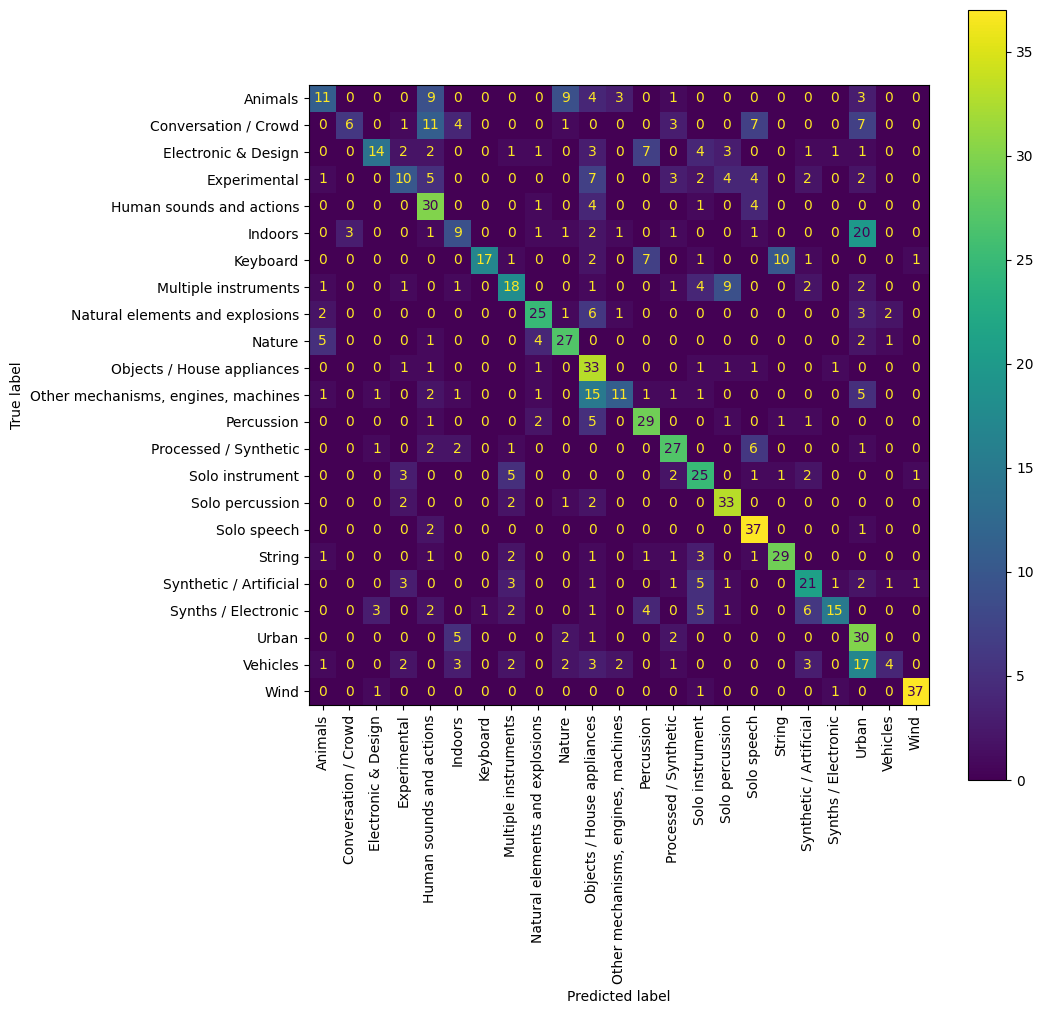

Classification report for mfcc:
                                     precision    recall  f1-score   support

                            Animals       0.31      0.12      0.18        40
               Conversation / Crowd       0.80      0.20      0.32        40
                Electronic & Design       0.27      0.15      0.19        40
                       Experimental       0.16      0.10      0.12        40
           Human sounds and actions       0.15      0.23      0.18        40
                            Indoors       0.50      0.15      0.23        40
                           Keyboard       0.00      0.00      0.00        40
               Multiple instruments       0.13      0.07      0.10        40
    Natural elements and explosions       0.11      0.15      0.12        40
                             Nature       0.28      0.28      0.28        40
         Objects / House appliances       0.19      0.50      0.28        40
Other mechanisms, engines, machines       0

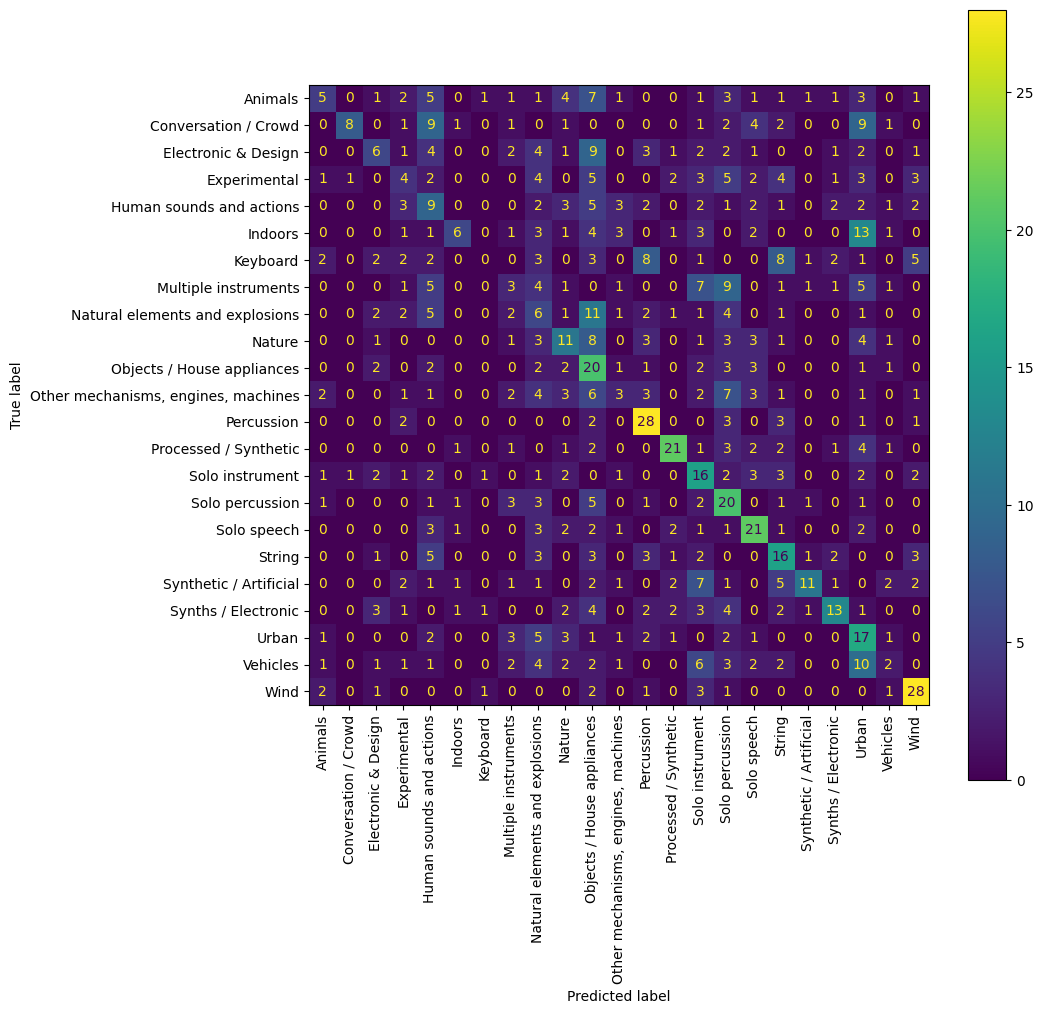

Classification report for clap:
                                     precision    recall  f1-score   support

                            Animals       0.81      0.53      0.64        40
               Conversation / Crowd       1.00      0.20      0.33        40
                Electronic & Design       0.86      0.80      0.83        40
                       Experimental       0.67      0.50      0.57        40
           Human sounds and actions       0.56      0.90      0.69        40
                            Indoors       0.52      0.33      0.40        40
                           Keyboard       0.97      0.85      0.91        40
               Multiple instruments       0.73      0.47      0.58        40
    Natural elements and explosions       0.83      0.97      0.90        40
                             Nature       0.71      0.88      0.79        40
         Objects / House appliances       0.63      0.93      0.75        40
Other mechanisms, engines, machines       0

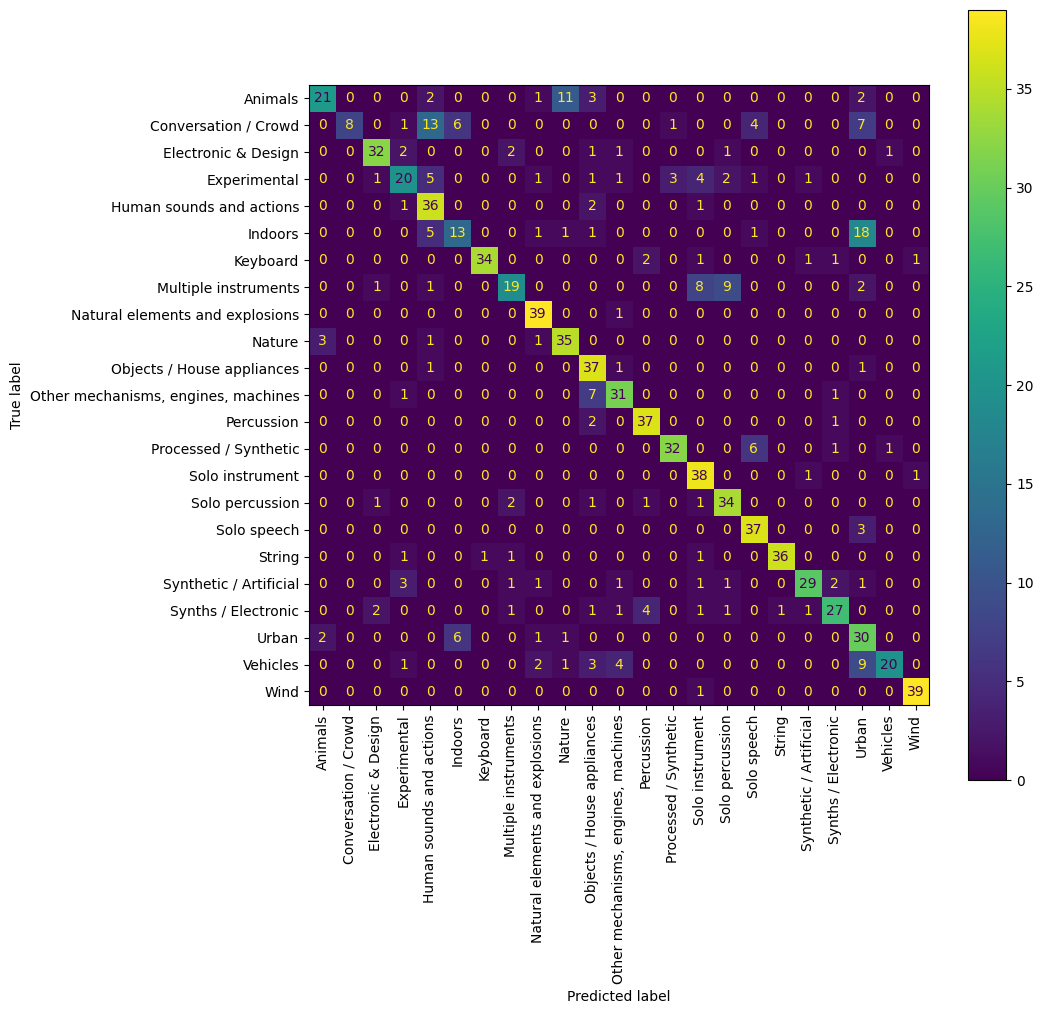

Classification report for fs_similarity:
                                     precision    recall  f1-score   support

                            Animals       0.27      0.10      0.15        40
               Conversation / Crowd       0.38      0.07      0.12        40
                Electronic & Design       0.57      0.20      0.30        40
                       Experimental       0.53      0.23      0.32        40
           Human sounds and actions       0.32      0.57      0.41        40
                            Indoors       0.25      0.17      0.21        40
                           Keyboard       1.00      0.30      0.46        40
               Multiple instruments       0.31      0.28      0.29        40
    Natural elements and explosions       0.33      0.47      0.39        40
                             Nature       0.47      0.55      0.51        40
         Objects / House appliances       0.21      0.50      0.30        40
Other mechanisms, engines, machine

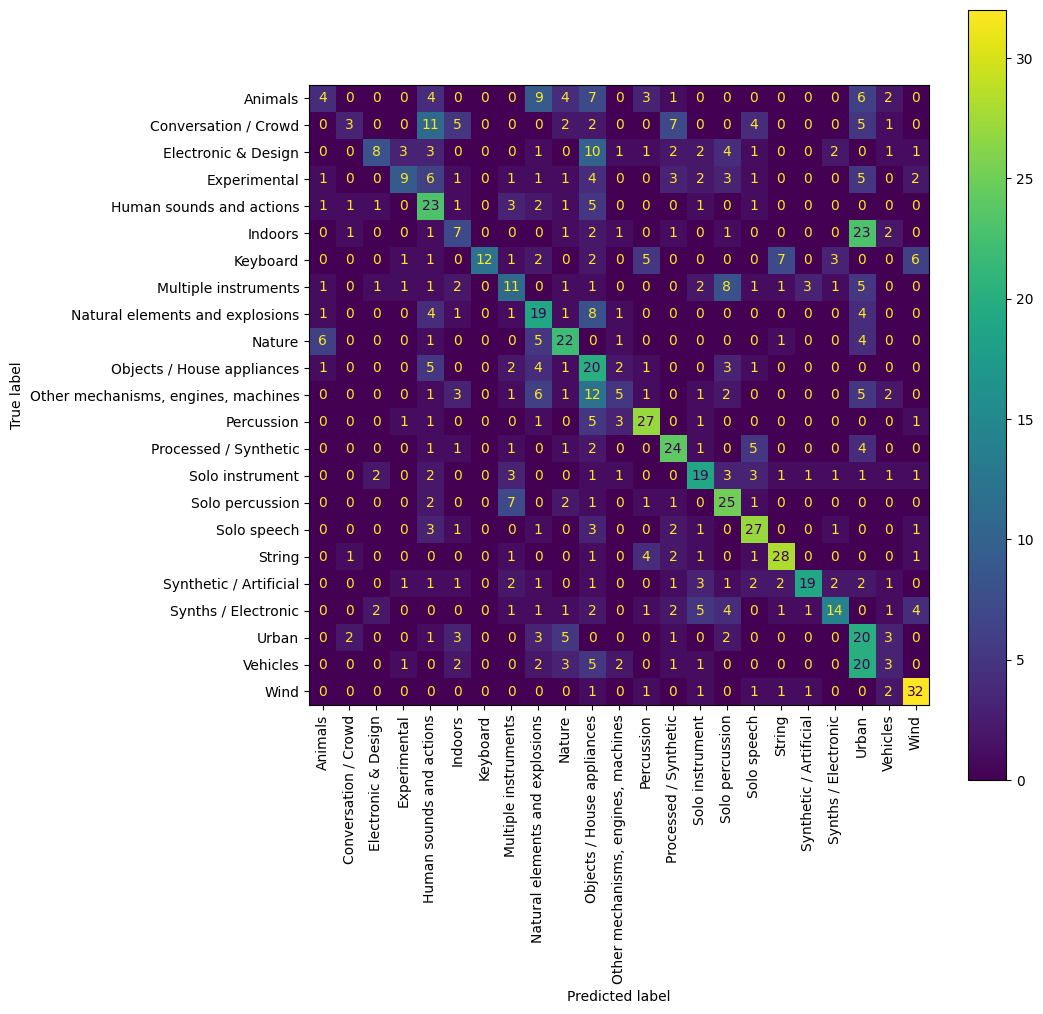

Classification report for fsdsinet MLP:
                                     precision    recall  f1-score   support

                            Animals       0.43      0.25      0.32        40
               Conversation / Crowd       0.80      0.20      0.32        40
                Electronic & Design       0.59      0.50      0.54        40
                       Experimental       0.36      0.33      0.34        40
           Human sounds and actions       0.57      0.75      0.65        40
                            Indoors       0.26      0.17      0.21        40
                           Keyboard       1.00      0.47      0.64        40
               Multiple instruments       0.52      0.42      0.47        40
    Natural elements and explosions       0.54      0.68      0.60        40
                             Nature       0.57      0.57      0.57        40
         Objects / House appliances       0.41      0.70      0.51        40
Other mechanisms, engines, machines

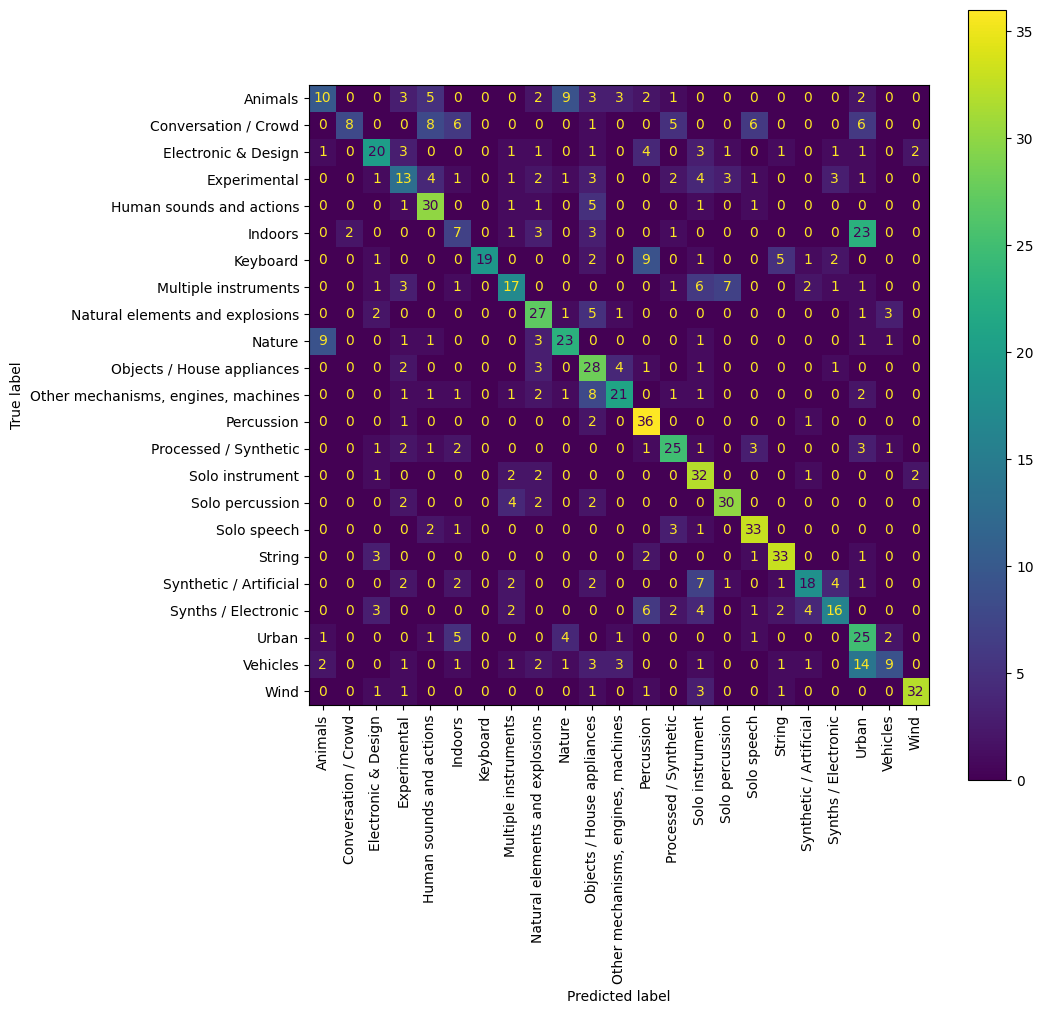

Classification report for mfcc MLP:
                                     precision    recall  f1-score   support

                            Animals       0.15      0.05      0.08        40
               Conversation / Crowd       0.60      0.07      0.13        40
                Electronic & Design       0.10      0.05      0.07        40
                       Experimental       0.14      0.07      0.10        40
           Human sounds and actions       0.21      0.42      0.28        40
                            Indoors       0.21      0.07      0.11        40
                           Keyboard       0.50      0.05      0.09        40
               Multiple instruments       0.29      0.20      0.24        40
    Natural elements and explosions       0.13      0.23      0.17        40
                             Nature       0.33      0.23      0.27        40
         Objects / House appliances       0.14      0.45      0.21        40
Other mechanisms, engines, machines    

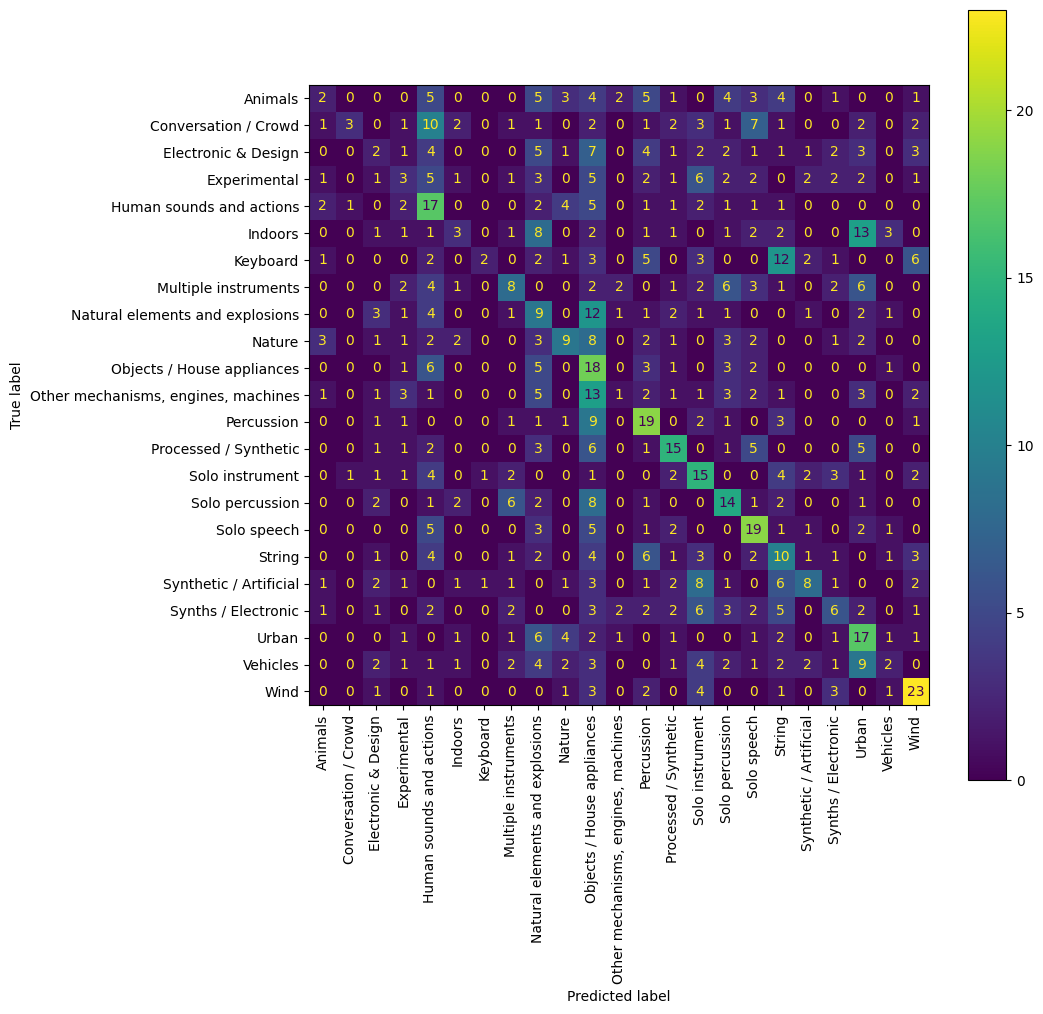

Classification report for clap MLP:
                                     precision    recall  f1-score   support

                            Animals       0.70      0.53      0.60        40
               Conversation / Crowd       1.00      0.20      0.33        40
                Electronic & Design       0.89      0.62      0.74        40
                       Experimental       0.61      0.42      0.50        40
           Human sounds and actions       0.55      0.82      0.66        40
                            Indoors       0.65      0.28      0.39        40
                           Keyboard       1.00      0.80      0.89        40
               Multiple instruments       0.79      0.68      0.73        40
    Natural elements and explosions       0.81      0.88      0.84        40
                             Nature       0.72      0.72      0.72        40
         Objects / House appliances       0.60      0.90      0.72        40
Other mechanisms, engines, machines    

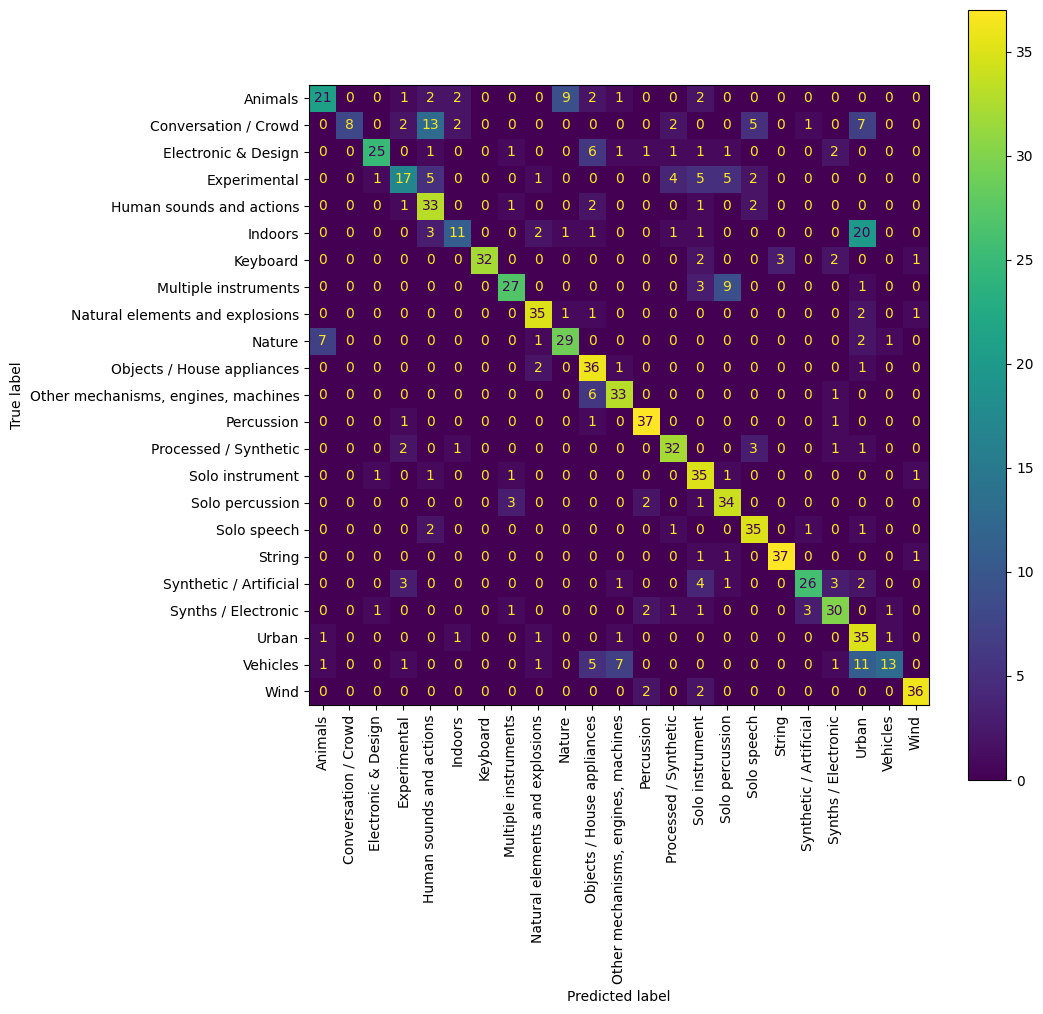

Classification report for fs_similarity MLP:
                                     precision    recall  f1-score   support

                            Animals       0.50      0.20      0.29        40
               Conversation / Crowd       0.31      0.10      0.15        40
                Electronic & Design       0.46      0.28      0.34        40
                       Experimental       0.14      0.10      0.12        40
           Human sounds and actions       0.33      0.55      0.42        40
                            Indoors       0.50      0.25      0.33        40
                           Keyboard       0.69      0.23      0.34        40
               Multiple instruments       0.32      0.23      0.26        40
    Natural elements and explosions       0.43      0.50      0.47        40
                             Nature       0.61      0.47      0.54        40
         Objects / House appliances       0.24      0.72      0.36        40
Other mechanisms, engines, mac

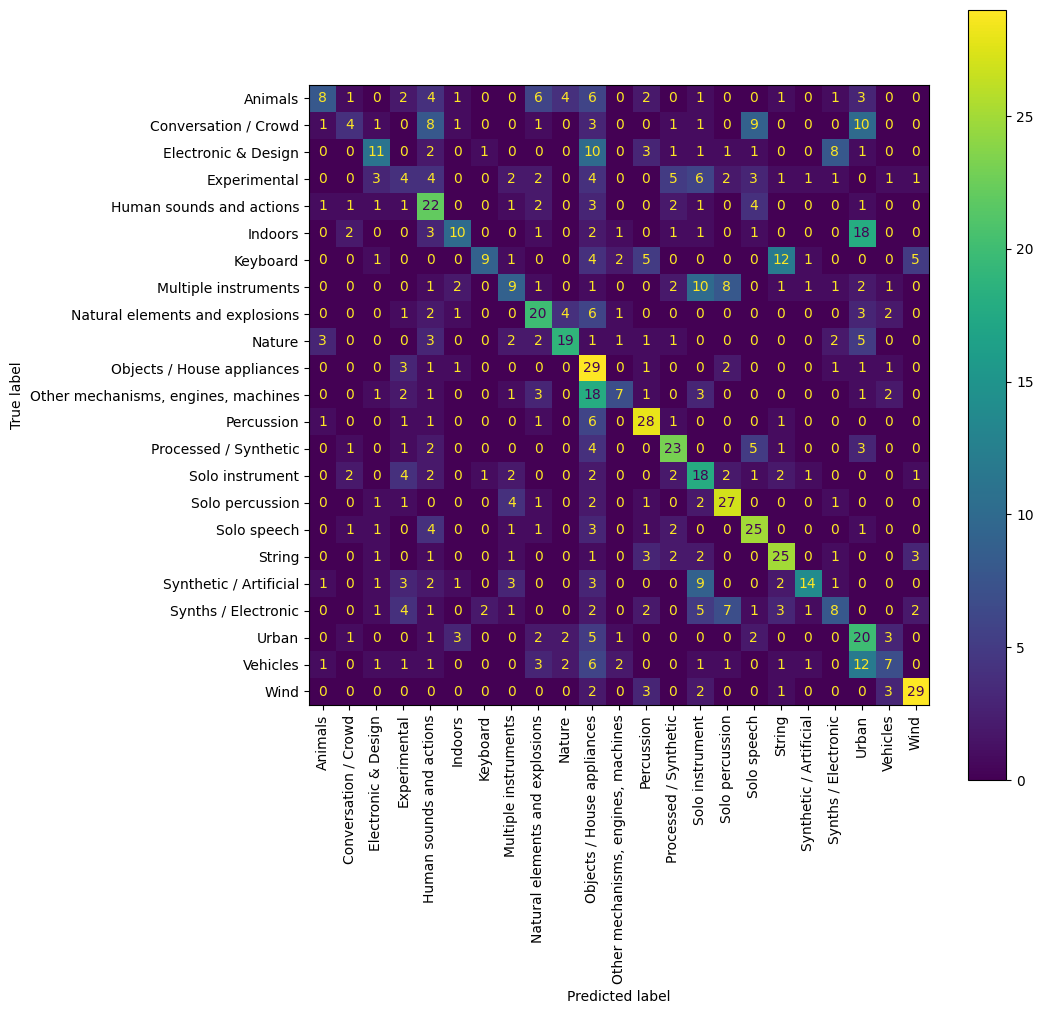

In [12]:
# Show classification report
def display_classification_report(y_test, y_pred, clf):
    class_report = classification_report(y_test, y_pred)
    print(class_report)

# Show confussion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    cm_display = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
    cm_display.plot(ax=ax)
    plt.xticks(rotation = 90)
    plt.show()

for model_name, model in models.items():
    print(f'Classification report for {model_name}:')
    display_classification_report(sets[model_name]['y_test'], predictions[model_name], model)

for model_name, model in mlp_models.items():
    print(f'Classification report for {model_name} MLP:')
    display_classification_report(sets[model_name]['y_test'], predictions_mlp[model_name], model)


## Audition misclassified sounds

In [11]:
# Randomply select 5 misclassifications and listen to them
misclassified_sounds = []
for misclassified_test_index in np.where(y_test != y_pred)[0]:
    dataset_df_index = test_df_indices[misclassified_test_index]
    misclassified_sounds.append([
        dataset_df.iloc[dataset_df_index]['sound_id'],
        y_test[misclassified_test_index],
        y_pred[misclassified_test_index]
    ])

for sound_id, ground_truth, predicted in random.sample(misclassified_sounds, 5):
    print('---------------------------------------')
    print(dataset_df[dataset_df['sound_id'] == sound_id]['title'].values[0])
    print("Ground truth: ", ground_truth)
    print("Predicted:", predicted)
    show_sound_player(sound_id)


NameError: name 'y_test' is not defined